In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
library(tidymodels)
install.packages("kknn")
library(kknn)
set.seed(3)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
cbb <- read_csv("https://raw.githubusercontent.com/naw333/College-Basketball-Data-Science/main/cbb.csv") 

Rows: 3523 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): TEAM, CONF, POSTSEASON, SEED
dbl (20): G, W, ADJOE, ADJDE, BARTHAG, EFG_O, EFG_D, TOR, TORD, ORB, DRB, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
#The training set will be used to perform a 5-fold cross-validation to select the k value 
#that optimizes the classifier’s performance based on the accuracy of the classifier. 
#The performance of the classifier will be tested using the test set, 
#then a new set of observations for basketball teams will be classified using the trained classifier. 
#The correlation coefficient will be calculated between each predictor variable and POSTSEASON, 
#and the result of this will be visualized as a bar graph.

In [6]:
cbb_modified <- cbb|> filter(POSTSEASON != "N/A")|>mutate(PERC= W/G) |> mutate(POSTSEASON=as_factor(POSTSEASON))|> mutate(TEAM = as_factor(TEAM))

cbb_short <- cbb_modified|> select(
                          PERC,
                          ADJOE,
                          ADJDE,
                          BARTHAG,
                          EFG_O,
                          EFG_D,
                          TOR,
                          TORD,
                          ORB,
                          DRB,
                          FTR,
                          ADJ_T,
                          POSTSEASON,
                          )
head(cbb_short)
cbb_split <- initial_split(cbb_short, prop = 0.75, strata = POSTSEASON)
cbb_train <- training(cbb_split)
cbb_test <- testing(cbb_split)
cbb_summ <- summarize(cbb_train, team_count = nrow(cbb_train), mean_ADJOE = mean(ADJOE), mean_ADJDE = mean(ADJDE), mean_ADJ_T = mean(ADJ_T), mean_ORB = mean(ORB), mean_TOR = mean(TOR), mean_PERC = mean(PERC))
cbb_summ

TEAM,PERC,ADJOE,ADJDE,EFG_O,TOR,TORD,ORB,FTR,2P_D,3P_D,ADJ_T,POSTSEASON,YEAR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
North Carolina,0.8250000,123.3,94.9,52.6,15.4,18.2,40.7,32.3,44.6,36.2,71.7,2ND,2016
Wisconsin,0.9000000,129.1,93.6,54.8,12.4,15.8,32.1,36.2,44.7,37.5,59.3,2ND,2015
Michigan,0.8250000,114.4,90.4,53.9,14.0,19.5,25.5,30.7,46.8,33.2,65.9,2ND,2018
Texas Tech,0.8157895,115.2,85.2,53.5,17.7,22.8,27.4,32.9,41.9,29.7,67.5,2ND,2019
Gonzaga,0.9487179,117.8,86.3,56.6,16.2,17.1,30.0,39.0,40.0,29.0,71.5,2ND,2017
Kentucky,0.7250000,117.2,96.2,49.9,18.1,16.1,42.0,51.8,44.9,32.2,65.9,2ND,2014


team_count,mean_ADJOE,mean_ADJDE,mean_ADJ_T,mean_ORB,mean_TOR,mean_PERC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
509,111.366,96.46837,67.72711,31.36739,17.4778,0.7263782


! Fold3: internal:
  There were 9 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2ND'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 r...



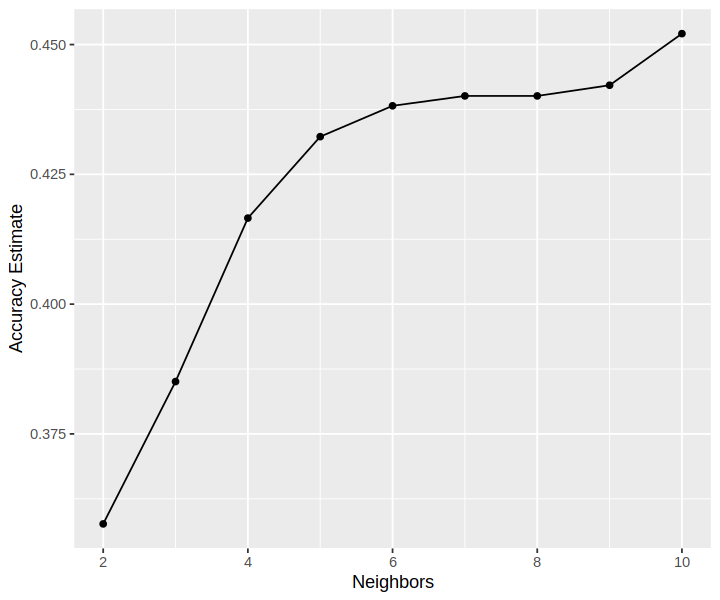

In [9]:
cbb_subset <- cbb_short|> select(POSTSEASON,
                                 ADJOE,
                                 ADJDE,
                                 BARTHAG,
                                 DRB,
                                 EFG_D,
                                 EFG_O,
                                 FTR,
                                 TOR,
                                 ORB)
names <- colnames(cbb_subset|>select(-POSTSEASON))
head(cbb_subset)

example_formula <- paste("POSTSEASON", "~", paste(names,collapse="+"))
example_formula

In [ ]:
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())
#create model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

#create 5-fold cross validation object 
cbb_vfold <- vfold_cv(cbb_subset, v = 5, strata = POSTSEASON)

#store the total number of predictors
n_total <- length(names)

#store selected predictors 
selected <- c()

#for every size form 1 to the toal number of predictors
for (i in 1:n_total) {
    #for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)){
        # create model string for this combinatin of predictors
        preds_new <- c(selected,names[[j]])
        model_string <- paste ("POSTSEASON", "~", paste(preds_new, collapse = "+"))

        #create a recipe from the model string 
        cbb_recipe <- recipe(as.formula(model_string),
                            data = cbb_subset) |>
                        step_scale(all_predictors())|>
                        step_center(all_predictors())

        #tune the KNN classifier with there predictors,
        #and collect the accuracy for the best K
        acc <- workflow()|>
            add_recipe(cbb_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = cbb_vfold, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
    
        #add this result to the dataframe 
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
        add_row(size = i,
                model_string = models[[jstar]],
                accuracy = accs[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
}
accuracies

In [ ]:
# Select only relevant predictors.
PREDICTOR_VARIABLES <- c("BARTHAG", "TOR", "ADJDE", "ORB", "ADJOE")

cbb_training_data_predictor_selected <- cbb_train |>
    select(POSTSEASON, all_of(PREDICTOR_VARIABLES))

head(cbb_training_data_predictor_selected)

In [ ]:
options(repr.plot.height = 12, repr.plot.width = 24)

cbb_training_data_predictor_selected |>
    # Normalize the data.
    select(all_of(PREDICTOR_VARIABLES)) |>
    scale() |>
    bind_cols(POSTSEASON = cbb_training_data_predictor_selected$POSTSEASON) |>

    # Create a scatterplot matrix.
    ggpairs(aes(alpha = 0.4, colour = POSTSEASON), columns = 1:length(PREDICTOR_VARIABLES)) +
        labs(title = "Scatterplot Matrix of Predictors with Correlation Coefficients") +
        theme_minimal() +
        theme(text = element_text(size = 20))